# Credit card fraud detection using Deep Neural Networks
*****

- Based on KERAS example: https://keras.io/examples/structured_data/imbalanced_classification/

In [5]:
'''
Needed libraries
'''
import csv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow_addons as tfa
from keras.utils.vis_utils import plot_model

from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

# Data
*****
- Download data from [here](https://www.kaggle.com/mlg-ulb/creditcardfraud).
- It contains transactions made by credit cards in September 2013 by European cardholders. 
- It presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. 
- The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.
- It contains only numerical input variables which are the result of a PCA transformation. 
- Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. 
- Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. 
- Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. - - The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. 
- Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

In [8]:
path = "/Users/rpezoa/Library/Mobile Documents/com~apple~CloudDocs/Research/imbalanced-class/data/"
df = pd.read_csv(path + "creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
values = df["Class"].value_counts()
print(values)

0    284315
1       492
Name: Class, dtype: int64


Text(1.28, 150, '0.2%')

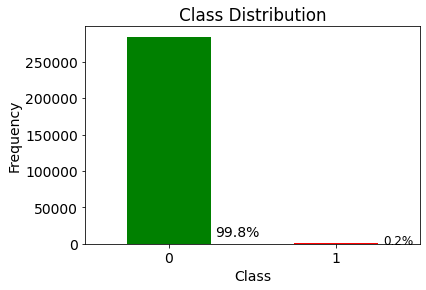

In [10]:
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)


pd.value_counts(df["Class"]).plot.bar(rot=0, color=["green", "red"])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.text(0.28, 10500,str(round(values[0]/(values[0]+values[1]),3)*100) + "%", fontsize=14)
plt.text(1.28, 150,  str(round(values[1]/(values[0]+values[1]),3)*100) + "%", fontsize=12)

## Checking missing attributes

In [11]:
def show_null(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    display(missing_data)
show_null(df)

,Total,Percent
Time,0,0.0
V16,0,0.0
Amount,0,0.0
V28,0,0.0
V27,0,0.0
V26,0,0.0
V25,0,0.0
V24,0,0.0
V23,0,0.0
V22,0,0.0


Text(0.5, 1.0, 'Correlation Heatmap')

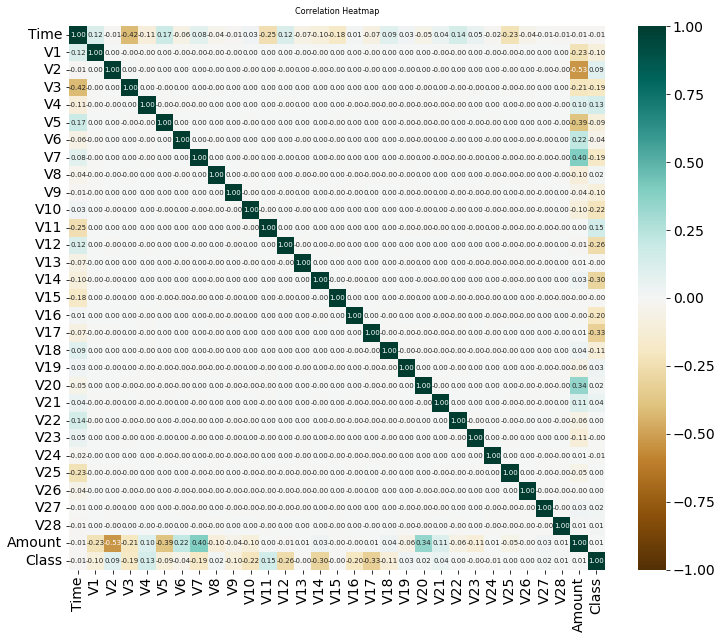

In [12]:
corr_matrix = df.corr()
plt.figure(figsize=(12, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG', annot = True, fmt=".2f", annot_kws={"size":7})
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':8}, pad=12)

## Training, testing

In [13]:
y = df["Class"]
y = y.astype(int)
X = df.iloc[:,1:-1]

In [14]:
print(X.shape, y.shape)

(284807, 29) (284807,)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,y, 
                                test_size=0.3, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, 
                                                  test_size=0.2, random_state=0)
n_classes = 2


In [16]:
counts = np.bincount(y_train.values)
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(y_train)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

print("Weight class 0: ", weight_for_0,6)
print("Weight class 1: ", weight_for_1)

Number of positive samples in training data: 281 (0.18% of total)
Weight class 0:  6.281012499214874e-06 6
Weight class 1:  0.0035587188612099642


# Deep Neural Network

### Loss functions
- Binary crossentropy
$$ $$



In [17]:
from keras.layers import Dense, Dropout
from keras.models import Sequential
import tensorflow  as tf



model = Sequential()
model.add(Dense(300, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(150, activation = "relu"))
model.add(Dense(100, activation = "relu"))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               9000      
                                                                 
 dense_1 (Dense)             (None, 150)               45150     
                                                                 
 dense_2 (Dense)             (None, 100)               15100     
                                                                 
 dense_3 (Dense)             (None, 50)                5050      
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 74,351
Trainable params: 74,351
Non-trainable params: 0
_________________________________________________________________


## Hyperparámetros
***

Esta red es entreanda usando los siguientes hiperparámetros:
- loss function: binary_cross_entropy
- optimize = SDG
- epochs = 5

pero esos valores son ajustables. Modificar los siguientes hyperparámetros:

- kernel_initializer
- Optimizer
- Batch_size, epochs
- Loss function


¿Qué valores de hiperparámetros se pueden utilizar?


In [18]:
metrics_m = [
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]

model.compile(optimizer=SGD(),
               loss='binary_crossentropy',
               metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

history = model.fit(X_train, y_train, epochs=5, 
                    verbose=1,
                    validation_data = (X_val, y_val))



Epoch 1/5
4985/4985 [==============================] - 10s 2ms/step - loss: 0.0496 - accuracy: 0.9981 - precision: 0.1739 - recall: 0.0142 - val_loss: 0.0185 - val_accuracy: 0.9982 - val_precision: 0.7500 - val_recall: 0.0400
Epoch 2/5
4985/4985 [==============================] - 10s 2ms/step - loss: 0.0192 - accuracy: 0.9983 - precision: 0.6744 - recall: 0.1032 - val_loss: 0.0145 - val_accuracy: 0.9983 - val_precision: 0.8750 - val_recall: 0.0933
Epoch 3/5
4985/4985 [==============================] - 12s 2ms/step - loss: 0.0105 - accuracy: 0.9987 - precision: 0.8598 - recall: 0.3274 - val_loss: 0.0082 - val_accuracy: 0.9987 - val_precision: 0.8667 - val_recall: 0.3467
Epoch 4/5
4985/4985 [==============================] - 11s 2ms/step - loss: 0.0079 - accuracy: 0.9988 - precision: 0.8146 - recall: 0.4377 - val_loss: 0.0058 - val_accuracy: 0.9991 - val_precision: 0.8679 - val_recall: 0.6133
Epoch 5/5
4985/4985 [==============================] - 16s 3ms/step - loss: 0.0140 - accuracy: 0

In [19]:
def show_history(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    plt.figure()
    plt.plot(train_loss,'r', label="train")
    plt.plot(val_loss,'g', label="validation")
    plt.legend()
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    
    
def show_metrics(y_pred,th):
    cm = confusion_matrix(y_test, y_pred>th)
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Fraud", "Fraud"])
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    d = classification_report(y_test, y_pred > th,output_dict=True)
    display(pd.DataFrame.from_dict(d))
    return y_pred

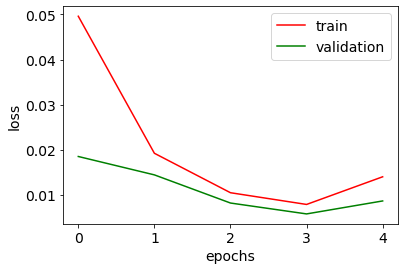

In [20]:
show_history(history)

[[85303     4]
 [   90    46]]


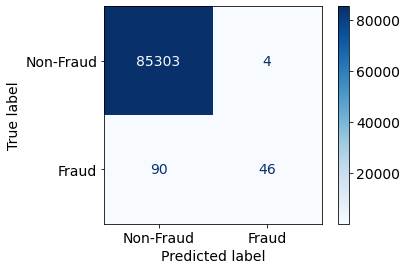

,0,1,accuracy,macro avg,weighted avg
precision,0.998946,0.920000,0.9989,0.959473,0.998820
recall,0.999953,0.338235,0.9989,0.669094,0.998900
f1-score,0.999449,0.494624,0.9989,0.747036,0.998646
support,85307.000000,136.000000,0.9989,85443.000000,85443.000000


array([[2.2082031e-03],
       [1.1714805e-05],
       [3.1853616e-03],
       ...,
       [8.6718798e-04],
       [1.9714596e-05],
       [9.0155005e-04]], dtype=float32)

In [21]:
y_pred = model.predict(X_test)
show_metrics(y_pred,.5)

In [22]:
y_pred

array([[2.2082031e-03],
       [1.1714805e-05],
       [3.1853616e-03],
       ...,
       [8.6718798e-04],
       [1.9714596e-05],
       [9.0155005e-04]], dtype=float32)